In [1]:
module_path = "/home/claysmyth/code/integrated_rcs_analysis/python"
#class_path = "sklearn_model/clustering_classification.py"
import sys
sys.path.append(module_path)
import matplotlib.pyplot as plt
import numpy as np
import glob
import polars as pl

import os
# Add src/papermill_notebooks directory to path to import baseline_summary_utils
current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, "src/papermill_notebooks"))
from baseline_summary_utils import *


import json

### Parameter cell (for running parameterized notebook via papermill)

### Config

Session Type is usually 'baseline' if only one baseline dataset was collected, or 'baseline_2' if a second baseline dataset was collected to combat distributional shift.

In [4]:
device_id = 'RCS01L'
session_type = 'baseline'
model_group = 'unsup_embeddable_models_15s_averaged'
first_n_of_each_session_to_drop = 0 # n is number of power_Band values to drop from the start of each session

# n is number of rows to drop from the start of each night after filtering for NREM
# Helps combat artifacts
# Only ran for 09L
drop_first_n_after_filtering_for_NREM = 0 # n is number of rows to drop from the start of each night after filtering for NREM
model_path = '/media/longterm_hdd/Clay/Sleep_aDBS/embeddable_models/{model_group}/{device_id}/ClusterClassificationModel_*/model.pkl'
window_length = 100
corr_threshold = 0.7

# Define a dictionary with settings for each device. 
# Use lists for values to match polars dataframe to dict conversion
settings_QA_dict = {
    'TDsampleRates': [500],
    'fft_interval': [1000],
    'Power_Band5': ['0.73-4.15'],
    'Power_Band6': ['4.64-12.45'],
    'Power_Band7': ['13.43-30.03'],
    'Power_Band8': ['31.01-59.81']
}

# File paths for accessing data and verifying session settings
session_settings_csv_template_path = "/media/longterm_hdd/Clay/Sleep_aDBS/data/{session_type}/{device}/session_settings/{session}/FftAndPowerSettings.csv"
session_data_base_path = "/media/longterm_hdd/Clay/Sleep_aDBS/data/{session_type}/{device}/session_reports/"
session_data_template_path = "/media/longterm_hdd/Clay/Sleep_aDBS/data/{session_type}/{device}/session_reports/{sessions}/raw_data.parquet"

sessions_to_skip = []

# Output directory base_path for saving averaged data
output_dir = "/media/longterm_hdd/Clay/Sleep_aDBS/bayes_opt_experiments/{participant}/{device}"

# Path to state_to_NREM_mapping.json (which should exist in the output_dir)
state_to_NREM_mapping_path = f"{output_dir}/rcs_state_to_NREM_mapping.json"

delta_power_column = 'Power_Band5'
SAMPLES_PER_HOUR = 1 / 4 / 60
NUM_SECONDS_FOR_POWER_AVERAGING = 15 # Number of seconds for power averaging. Note that RC+S stores this as FFT_INTERVAL * SAMPLES_TO_AVERAGE. For RC+S this is 1000ms * 15 cycles.

# Filter to only include NREM data for calculating rolling average
filter_for_NREM = True

# How many hours to extrapolate the data
extrapolation_duration_hours = 8.0

### pipeline

In [3]:
def find_binary_pattern_match(df: pl.DataFrame, column: str, window: list | np.ndarray, 
                             match_threshold: float = 1.0) -> tuple[int, pl.DataFrame]:
    """
    Optimized version specifically for binary vectors.
    Uses Hamming similarity (fraction of matching bits).
    
    Parameters:
    -----------
    df : pl.DataFrame
        Input dataframe
    column : str
        Column name with binary values
    window : list | np.ndarray
        Binary pattern to match
    match_threshold : float
        Fraction of bits that must match (1.0 = exact match)
    
    Returns:
    --------
    tuple[int, pl.DataFrame] : (first_matching_index, original_dataframe)
    """
    
    window_size = len(window)
    window = np.array(window, dtype=np.int8)
    
    col_values = df.get_column(column).to_numpy(zero_copy_only=False).astype(np.int8)
    
    if len(col_values) < window_size:
        return (-1, df)
    
    # For binary vectors, check fraction of matching elements
    for i in range(len(col_values) - window_size + 1):
        segment = col_values[i:i+window_size]
        
        # Hamming similarity: fraction of matching bits
        matches = np.sum(segment == window) / window_size
        
        if matches >= match_threshold:
            return i
    
    return -1

In [ ]:
# Get device data
nights = []
bad_sessions = []
good_sessions = []
NREM_times = [] # Time spent in State 1 for each night (seconds)
linear_model = get_model(device_id, model_path, model_group)
participant = device_id[:-1]
output_dir = output_dir.format(participant=participant, device=device_id)
window = np.ones(window_length)

for sessions_group_path in glob.glob(f"{session_data_base_path.format(session_type=session_type, device=device_id)}/*"):

    print("")
    bad_session = False

    sessions_group = sessions_group_path.split('/')[-1]
    print(f"Processing sessions group {sessions_group}")

    sessions = sessions_group.split('_')
    for session in sessions:
        print(f"Checking session {session}")
        session_settings = get_session_settings(device_id, session, session_type, session_settings_csv_template_path)
        if not verify_session_settings(session_settings.to_dict(as_series=False), settings_QA_dict):
            print(f"Session {session} has incorrect settings")
            bad_sessions.append(sessions_group)
            bad_session = True
        elif session in sessions_to_skip:
            print(f"Skipping session {session} because it is in the sessions_to_skip list")
            bad_sessions.append(sessions_group)
            bad_session = True
        else:
            good_sessions.append(sessions_group)

    if bad_session:
        print(f"Not proceeding with session group {sessions_group}")
        continue

    sessions_group_path = os.path.basename(sessions_group_path)
    try:
        df = get_device_data(session_data_template_path, device_id, session_type, sessions_group_path, first_n_of_each_session_to_drop=first_n_of_each_session_to_drop)
    except:
        print(f"Could not retrieve {device_id} - {sessions_group_path}")

    # Average over time segments
    df_averaged = (
        # Average over time segments
        average_over_time_segments(
            df=df,
            time_column='localTime',
            columns_to_average=['^Power_Band.*[5-8]$'],
            interval='15s',
            period='15s',
            group_by=['SessionNumber']
        )
        # Add device column
        # .with_columns(pl.lit(device_id).alias('device'))
    )


    df_averaged = add_state_predictions(df_averaged, linear_model)

    inferred_first_n_after_filtering_for_NREM = find_binary_pattern_match(df_averaged, 'State', window=window, match_threshold=corr_threshold)
    df_averaged = df_averaged.slice(inferred_first_n_after_filtering_for_NREM, None)

    if filter_for_NREM:
        df_averaged = df_averaged.filter(pl.col('State') == 1)
        NREM_times.append(df_averaged.height * NUM_SECONDS_FOR_POWER_AVERAGING) # Assumes power averaging is done every 15 seconds
    else:
        NREM_times.append(0) # Assumes one FFT per second (as validated by the check session settings)
    
    # if drop_first_n_after_filtering_for_NREM > 0:
    #     df_averaged = df_averaged.slice(drop_first_n_after_filtering_for_NREM, None)

    if (df_length := df_averaged.height * SAMPLES_PER_HOUR) < 1:
        print(f"Not enough samples in {device_id} - {sessions_group_path}. Only has State 1 time of {df_length} hours")
        print("Skipping and contining.. ")
        continue

    df_averaged = extrapolate_column(df_averaged, column_name=delta_power_column, extrapolation_duration_hours=extrapolation_duration_hours, num_seconds_for_power_averaging=NUM_SECONDS_FOR_POWER_AVERAGING)
    df_averaged = add_running_average(df_averaged, delta_power_column)
    nights.append(df_averaged)

In [ ]:
nights_fig = plot_nights_power_band(nights)

nights_fig.show()

In [ ]:
# Combine Power_Band5_running_average from all nights into a single dataframe
combined_df = None

for night_id, df in enumerate(nights):
    # Extract SessionNumber and Time_Since_Start_Seconds
    session_numbers = df["SessionNumber"].drop_nulls().unique().to_list()
    session_column_name = "_".join(session_numbers)
    
    # Create a temporary dataframe with renamed power column
    temp_df = df.select(
        ["Time_Since_Start_Seconds", f"{delta_power_column}_running_average"]
    ).rename({f"{delta_power_column}_running_average": session_column_name})
    
    # Combine with the main dataframe using horizontal concat
    if combined_df is None:
        combined_df = temp_df
    else:
        combined_df = combined_df.join(
            temp_df, 
            on="Time_Since_Start_Seconds", 
            how="full",
            coalesce=True
        )

# Display the combined dataframe
combined_df.sort("Time_Since_Start_Seconds").head(10)


In [110]:
combined_df_interp = (
    # I think join operation doesn't preserve order. Re-sorting to ensure correct order.
    combined_df.sort("Time_Since_Start_Seconds")
        .with_columns(
            pl.col("^Session.*$").interpolate()
        )
        .with_columns(
            Mean=pl.mean_horizontal(pl.col("^Session.*$"))
        )
)

mat = combined_df_interp.select(pl.col("^Session.*$", "Mean")).to_numpy()
std = np.std(mat, axis=1)
combined_df_interp = combined_df_interp.with_columns(
    Std=pl.Series(name="Std", values=std)
)


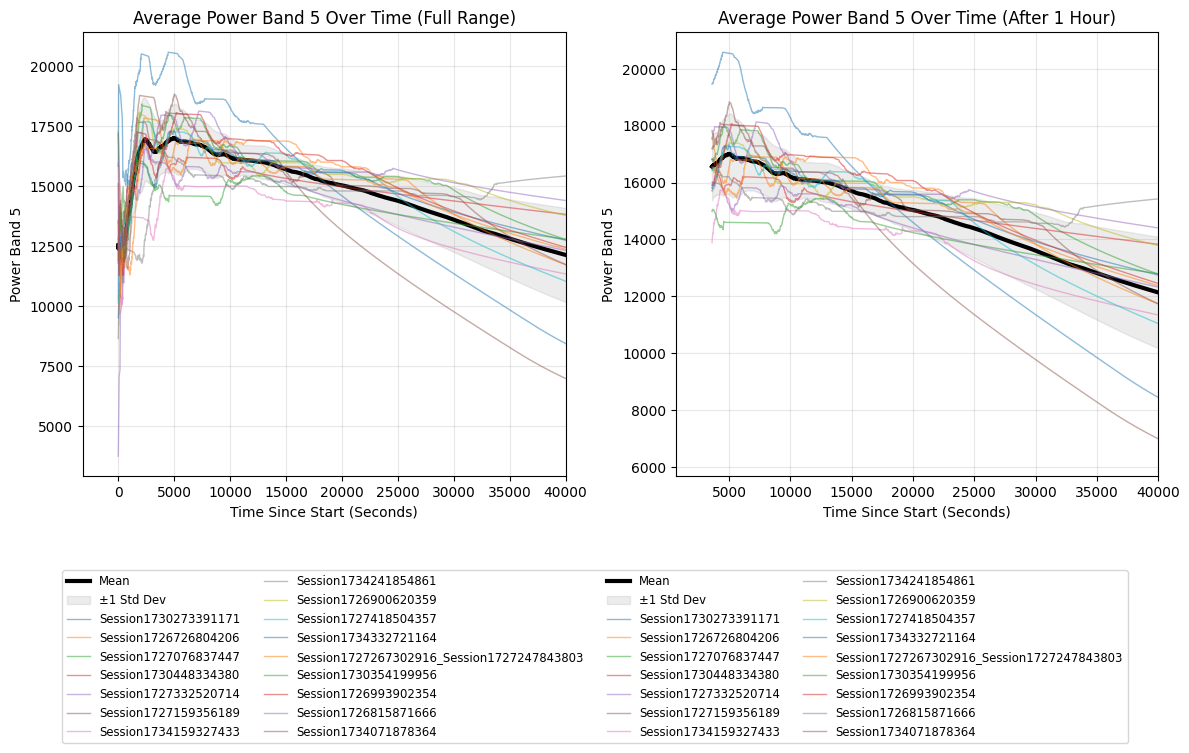

In [124]:
# Create line plots of Time_Since_Start_Seconds vs Mean and individual sessions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Get all session columns
session_columns = [col for col in combined_df_interp.columns if "Session" in col]

# Sort by time to ensure proper line plotting (using Polars)
plot_data = combined_df_interp.sort("Time_Since_Start_Seconds")

# Create the first plot (full range)
# Plot mean with thicker line
time_data = plot_data.get_column("Time_Since_Start_Seconds").to_numpy()
mean_data = plot_data.get_column("Mean").to_numpy()
std_data = plot_data.get_column("Std").to_numpy()

# Plot mean with standard deviation as shaded region
ax1.plot(time_data, mean_data, linewidth=3, color='black', label='Mean')
ax1.fill_between(time_data, mean_data - std_data, mean_data + std_data, 
                 color='gray', alpha=0.15, label='±1 Std Dev')

# Plot randomly selected sessions with thinner, semi-transparent lines
for session in session_columns:
    ax1.plot(plot_data.get_column("Time_Since_Start_Seconds"), 
             plot_data.get_column(session), 
             linewidth=1, alpha=0.5, label=session)
ax1.set_title("Average Cortical Delta Power Over Time (Full Range)")
ax1.set_xlabel("Time Since Start (Seconds)")
ax1.set_ylabel("Cortical Delta Power")
ax1.grid(True, alpha=0.3)
ax1.set_xlim(right=40_000)  # Set maximum x-axis limit to 40,000

# Create the second plot (starting at x=3600)
filtered_data = plot_data.filter(pl.col("Time_Since_Start_Seconds") >= 3600)
filtered_time = filtered_data.get_column("Time_Since_Start_Seconds").to_numpy()
filtered_mean = filtered_data.get_column("Mean").to_numpy()
filtered_std = filtered_data.get_column("Std").to_numpy()

# Plot mean with standard deviation as shaded region
ax2.plot(filtered_time, filtered_mean, linewidth=3, color='black', label='Mean')
ax2.fill_between(filtered_time, filtered_mean - filtered_std, filtered_mean + filtered_std, 
                 color='gray', alpha=0.15, label='±1 Std Dev')

# Plot randomly selected sessions with thinner, semi-transparent lines
for session in session_columns:
    ax2.plot(filtered_data.get_column("Time_Since_Start_Seconds"), 
             filtered_data.get_column(session), 
             linewidth=1, alpha=0.5, label=session)
ax2.set_title("Average Cortical Delta Power Over Time (After 1 Hour)")
ax2.set_xlabel("Time Since Start (Seconds)")
ax2.set_ylabel("Cortical Delta Power")
ax2.grid(True, alpha=0.3)
ax2.set_xlim(right=40_000)  # Set maximum x-axis limit to 40,000

# Add legend to a separate figure area to avoid cluttering
plt.figlegend(loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=4, fontsize='small')

# Add some styling
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Make room for the legend at the bottom

aggregate_fig = fig

plt.show()

## Save the data and plots

In [ ]:
os.makedirs(output_dir, exist_ok=True)

# Save the dataframe
combined_df_interp.write_parquet(os.path.join(output_dir, "rolling_avg_delta_power_for_each_baseline_night.parquet"))

# Save the state1 times
with open(os.path.join(output_dir, "NREM_times_and_stats.json"), "w") as f:
    json.dump({
        "NREM_times_seconds": NREM_times,
        "mean": np.mean(NREM_times),
        "std": np.std(NREM_times)
    }, f)

# Save the figures
nights_fig.savefig(os.path.join(output_dir, "delta_power_for_each_night_fig.png"), dpi=300, bbox_inches="tight")
aggregate_fig.savefig(os.path.join(output_dir, "aggregate_running_avg_delta_power_across_nights_fig.png"), dpi=300, bbox_inches="tight")

print(f"Data and figures saved to {output_dir} directory")

Data and figures saved to /media/longterm_hdd/Clay/Sleep_aDBS/bayes_opt_experiments/RCS09/RCS09L directory
